In [1]:
import javabridge
import bioformats
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.decomposition import NMF
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
from PIL import Image
import imageio
from scipy.integrate import simps
from sklearn.cluster import KMeans

In [2]:
javabridge.start_vm(class_path=bioformats.JARS)

# Class for w/o zstack

In [4]:
class Spectrum_Analysis_no_zstack:
    """ 
    For analyzing spectrum of image data w/o zstacks
    """
    def __init__(self, raw_data_filename, unmixed_filename, bin_size, Num_pixels, Num_CH, organelle1, organelle2, start_nm):
        self.raw_data_filename = raw_data_filename
        self.unmixed_filename = unmixed_filename
        self.bin_size = bin_size
        self.Num_pixels = Num_pixels
        self.Num_CH = Num_CH
        self.organelle1 = organelle1
        self.organelle2 = organelle2
        self.start_nm = start_nm

        # Load raw data
        self.Raw_data = np.empty([self.Num_pixels, self.Num_pixels, self.Num_CH])
        image_temp = bioformats.load_image(
            path=f'C:\\Users\\admin\\OneDrive - Washington University in St. Louis\\PhD\\Research\\Biophys\\image_data\\{self.raw_data_filename}.nd2',
            c=None,
            rescale=False
        )
        self.Raw_data[:, :, :] = image_temp
        
        if self.unmixed_filename == False:
            pass
        else:
            # Load unmixed data
            self.Unmixed_data = np.empty([self.Num_pixels, self.Num_pixels, 2])
            image_temp = bioformats.load_image(
                path=f'C:\\Users\\admin\\OneDrive - Washington University in St. Louis\\PhD\\Research\\Biophys\\image_data\\{self.unmixed_filename}.nd2',
                c=None,
                rescale=False
            )
            self.Unmixed_data[:, :, :] = image_temp

            # Specify array of organelle
            self.arr_organelle1 = self.Unmixed_data[:, :, 0]
            self.arr_organelle2 = self.Unmixed_data[:, :, 1]

        # x-axis for the spectrum later on
        self.xaxis = [f'{a+1} ({self.start_nm + self.bin_size * a})' for a in range(self.Num_CH)]
        self.xvalues = np.array([a+1 for a in range(self.Num_CH)])
        self.xvalues_nm = np.array([self.start_nm + self.bin_size * a for a in range(self.Num_CH)])
    
    def normalize_data(self):
        area_under_curve = simps(self.Raw_data, self.xvalues_nm, axis=-1)
        normalized_matrix = self.Raw_data / area_under_curve[:, :, np.newaxis]
        return normalized_matrix
    
    def remove_saturated_pix(self):
        # Location of saturated pixels
        ind_saturated = np.where(self.Raw_data >= 4050)
        # Mask for the saturated pixels
        mask_saturated =  np.ones(self.Raw_data[:,:,0].shape)
        # Set saturated to zero across all channels
        mask_saturated[ind_saturated[0],ind_saturated[1]] = 0
        processed_matrix = self.Raw_data*mask_saturated[:,:,np.newaxis]
        return processed_matrix, ind_saturated
        
        
    def generate_scatter_plot(self):
        def top10pixels(array1, array2):
            # Create a boolean mask where the condition is true for elements in array2 equal to 0
            mask = (array2 == 0)
            # Use the boolean mask to index array1, extracting values where the corresponding element in array2 is 0
            result = array1[mask]
            # Sort the result array in increasing order
            sorted_result = np.sort(result)
            # Ignore saturated pixels
            filtered = sorted_result[sorted_result <= 4000]
            # Get the top 10 numbers from the sorted result w/o saturated pixels
            top_10_numbers = filtered[-10:]
            return top_10_numbers

        organelle1_top10 = top10pixels(self.arr_organelle1, self.arr_organelle2)
        organelle2_top10 = top10pixels(self.arr_organelle2, self.arr_organelle1)

        def indx_top10pixels(array1, array2, top10pixels_array1):
            condition = np.logical_and(np.logical_and(array2 == 0, array1 >= np.min(top10pixels_array1)), array1 <= np.max(top10pixels_array1))
            indices = np.where(condition)
            return indices

        # Find indices of points that satisfy the condition
        indx_top10org1 = indx_top10pixels(self.arr_organelle1, self.arr_organelle2, organelle1_top10)
        indx_top10org2 = indx_top10pixels(self.arr_organelle2, self.arr_organelle1, organelle2_top10)

        # Plot the 2 arrays in a scatter plot
        plt.scatter(self.arr_organelle2, self.arr_organelle1, alpha=0.3)

        # Highlight the selected point
        plt.scatter(self.arr_organelle2[indx_top10org1], self.arr_organelle1[indx_top10org1], color='red',
                    label=f'${self.organelle2} = 0, {self.organelle1} \geq {np.min(organelle1_top10)}$')
        plt.scatter(self.arr_organelle2[indx_top10org2], self.arr_organelle1[indx_top10org2], color='green',
                    label=f'${self.organelle2} \geq {np.min(organelle2_top10)}, {self.organelle1} = 0$')

        # Add labels and title
        plt.ylabel(f'Pixel intensity ({self.organelle1})')
        plt.xlabel(f'Pixel intensity ({self.organelle2})')

        # Display the legend
        plt.legend()

        return plt, indx_top10org1, indx_top10org2
    
    def generate_scatter_plot_varNumpixels(self,saturated_pix, Num_toppixels):
        def select_pix(array1, array2):
            # Create a boolean mask where the condition is true for elements in array2 equal to 0
            mask = (array2 == 0)
            # Use the boolean mask to index array1, extracting values where the corresponding element in array2 is 0
            result = array1[mask]
            # Sort the result array in increasing order
            sorted_result = np.sort(result)
            # Ignore saturated pixels
            filtered = sorted_result[np.logical_and(100 <= sorted_result, sorted_result <= 4050)]
            # Get the top pixels from the sorted result w/o saturated pixels
            top_numbers = filtered[-Num_toppixels:]
            return top_numbers
        
        def indx_select_pix(array1, array2, select_pix_array1):
            condition = np.logical_and(np.logical_and(array2 == 0, array1 >= np.min(select_pix_array1)), array1 <= np.max(select_pix_array1))
            indices = np.where(condition)
            return indices
        
        if saturated_pix == False:
            # Location of saturated pixels
            ind_saturated = np.where(self.Raw_data >= 4050)
            # Mask for the saturated pixels
            mask_saturated =  np.ones(self.arr_organelle1.shape)
            # Set saturated to zero across all channels
            mask_saturated[ind_saturated[0],ind_saturated[1]] = 0
            
            # Apply to unmixed data
            arr_organelle1_nosat = self.arr_organelle1*mask_saturated
            arr_organelle2_nosat = self.arr_organelle2*mask_saturated
            
            # Pixels that we are sure of to be in a certain organelle (based from unmixed data)
            organelle1_pix = select_pix(arr_organelle1_nosat, arr_organelle2_nosat)
            organelle2_pix = select_pix(arr_organelle2_nosat, arr_organelle1_nosat)

            # Find indices of points that satisfy the condition
            indx_pixorg1 = indx_select_pix(arr_organelle1_nosat, arr_organelle2_nosat, organelle1_pix)
            indx_pixorg2 = indx_select_pix(arr_organelle2_nosat, arr_organelle1_nosat, organelle2_pix)

            # Plot the 2 arrays in a scatter plot
            plt.scatter(arr_organelle2_nosat, arr_organelle1_nosat, alpha=0.3)

            # Highlight the selected point
            plt.scatter(arr_organelle2_nosat[indx_pixorg1], arr_organelle1_nosat[indx_pixorg1], color='red',
                        label=f'${self.organelle2} = 0, {self.organelle1} \geq {np.min(organelle1_pix)}$')
            plt.scatter(arr_organelle2_nosat[indx_pixorg2], arr_organelle1_nosat[indx_pixorg2], color='green',
                        label=f'${self.organelle2} \geq {np.min(organelle2_pix)}, {self.organelle1} = 0$')
        else:
            # Pixels that we are sure of to be in a certain organelle (based from unmixed data)
            organelle1_pix = select_pix(self.arr_organelle1, self.arr_organelle2)
            organelle2_pix = select_pix(self.arr_organelle2, self.arr_organelle1)

            # Find indices of points that satisfy the condition
            indx_pixorg1 = indx_select_pix(self.arr_organelle1, self.arr_organelle2, organelle1_pix)
            indx_pixorg2 = indx_select_pix(self.arr_organelle2, self.arr_organelle1, organelle2_pix)

            # Plot the 2 arrays in a scatter plot
            plt.scatter(self.arr_organelle2, self.arr_organelle1, alpha=0.3)

            # Highlight the selected point
            plt.scatter(self.arr_organelle2[indx_pixorg1], self.arr_organelle1[indx_pixorg1], color='red',
                        label=f'${self.organelle2} = 0, {self.organelle1} \geq {np.min(indx_pixorg1)}$')
            plt.scatter(self.arr_organelle2[indx_pixorg2], self.arr_organelle1[indx_pixorg2], color='green',
                        label=f'${self.organelle2} \geq {np.min(indx_pixorg2)}, {self.organelle1} = 0$')
            

        # Add labels and title
        plt.ylabel(f'Pixel intensity ({self.organelle1})')
        plt.xlabel(f'Pixel intensity ({self.organelle2})')

        # Display the legend
        plt.legend()

        return plt, indx_pixorg1, indx_pixorg2

    
    def generate_NMF_comp(self,ymin,ymax,xmin,xmax):
        NMF_OrigMatrix = []
        for k in range(self.Num_CH):
            matrix = self.Raw_data[ymin:ymax,xmin:xmax,k]
            NMF_OrigMatrix.append(matrix.flatten())

        NMF_OrigMatrix_arr = np.array(NMF_OrigMatrix)
        # initialize the model
        model = NMF(n_components=3, init='nndsvd', random_state=0, max_iter=1500)
        W = model.fit_transform(np.log(NMF_OrigMatrix_arr+1.0))
        H = model.components_
        V = W @ H
        
        DemixedComp1 =  np.exp(H[0,:]).reshape(self.Raw_data[ymin:ymax,xmin:xmax,1].shape)
        DemixedComp2 =  np.exp(H[1,:]).reshape(self.Raw_data[ymin:ymax,xmin:xmax,1].shape)
        DemixedComp3 =  np.exp(H[2,:]).reshape(self.Raw_data[ymin:ymax,xmin:xmax,1].shape)
        
        return DemixedComp1, DemixedComp2, DemixedComp3
    
    def generate_Spectrum(self, x_ind, y_ind, Num_CHtocombi):
        spectrum_pix = self.Raw_data[y_ind, x_ind, :] 
        
        if Num_CHtocombi == 0:
            plt.plot(self.xaxis, spectrum_pix, color='gray', marker='o')
            plt.xticks(self.xaxis, rotation=90)
            plt.xlabel('CH # (wavelength in nm)')
        else:
            consecutive_means = []
            for i in range(0, len(spectrum_pix) - 1, Num_CHtocombi):
                    mean_value = np.mean(spectrum_pix[i:i+Num_CHtocombi])
                    consecutive_means.append(mean_value)
            
            consecutive_means = np.asarray(consecutive_means)
            # print(len(consecutive_means))
            plt.plot(range(1,len(consecutive_means)+1), consecutive_means, color='gray', marker='o')
            plt.xlabel('CH # ')
            
        plt.ylim(bottom=0)
        # Adjust layout to prevent overlapping
        plt.tight_layout()
        
        return plt
    
    def generate_normSpectrum(self, x_ind, y_ind, Num_CHtocombi):
        spectrum_pix = self.Raw_data[y_ind, x_ind, :] 
        
        if Num_CHtocombi == 0:
            area_under_curve = simps(spectrum_pix, self.xvalues_nm)
            norm_spectrum_pix = spectrum_pix/area_under_curve
            plt.plot(self.xaxis, norm_spectrum_pix, color='gray', marker='o')
            plt.xticks(self.xaxis, rotation=90)
            plt.xlabel('CH # (wavelength in nm)')
        else:
            consecutive_means = []
            combi_xvalues_nm = []
            combi_CH = []
            for i in range(0, len(spectrum_pix) - 1, Num_CHtocombi):
                    mean_value = np.mean(spectrum_pix[i:i+Num_CHtocombi])
                    consecutive_means.append(mean_value)
                    combi_xvalues_nm.append(np.mean(self.xvalues_nm[i:i+Num_CHtocombi]))
                    combi_CH.append(np.array(range(self.Num_CH))[i:i+Num_CHtocombi] + 1)
            
            consecutive_means = np.asarray(consecutive_means)
            combi_xvalues_nm = np.asarray(combi_xvalues_nm)
            # print(len(consecutive_means))
            # print(len(combi_xvalues_nm))
            # print(consecutive_means)
            # print(combi_xvalues_nm)
            
            area_under_curve = simps(consecutive_means, combi_xvalues_nm)
            norm_consecutive_means = consecutive_means/area_under_curve
            
            plt.plot([f'{combi_CH[a][0]}-{combi_CH[a][-1]} ({combi_xvalues_nm[a]})' for a in range(len(combi_xvalues_nm))], norm_consecutive_means, label = f'({x_ind},{y_ind})', marker='o')
            plt.xticks(rotation=90)
            plt.xlabel(r'CH # ($\lambda$ in nm)')
            
        plt.ylim(bottom=0)
        # Adjust layout to prevent overlapping
        plt.tight_layout()
        
        return plt
    
        
    def generate_normSpectrumbyAVE(self, indx_pixorg):
        values = []
        area_under_curve_list = []
        values_norm_Iinfo_list = []
        for ind in range(len(indx_pixorg[0])):
            values_along_CH = self.Raw_data[indx_pixorg[0][ind], indx_pixorg[1][ind], :]
            # Calculate the definite integral of the curve
            area_under_curve = simps(values_along_CH, self.xvalues_nm)
            norm_values_along_CH = values_along_CH / area_under_curve
            values.append(norm_values_along_CH)
            area_under_curve_list.append(area_under_curve)
        
        # Calculating mean and std
        meanI = np.mean(area_under_curve_list, axis=0)
        
        # Normalize the curve by dividing each data point by the area under the curve
        for ind in range(len(values)):
            values_norm_Iinfo = values[ind]*meanI
            values_norm_Iinfo_list.append(values_norm_Iinfo)
            
            plt.plot(self.xaxis, values_norm_Iinfo, color='gray', marker='o')
            plt.xticks(self.xaxis, rotation=90)
            plt.xlabel('CH # (wavelength in nm)')
            
        # Plotting mean and std
        mean = np.mean(values_norm_Iinfo_list, axis=0)
        std = np.std(values_norm_Iinfo_list, axis=0, ddof=1)
        
        plt.plot(self.xaxis, mean, color='#CC4F1B', marker='o',label='Mean')
        plt.fill_between(self.xaxis, mean-std, mean+std,
            alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848',label='Std')
        
        plt.ylim(bottom=0)
        
        # Adjust layout to prevent overlapping
        plt.tight_layout()
        
        return plt, mean, values_norm_Iinfo_list
    
    def generate_normSpectrum_combi(self, indx_pixorg, Num_CHtocombi):
        values = []
        for ind in range(len(indx_pixorg[0])):
            values_along_CH = self.Raw_data[indx_pixorg[0][ind], indx_pixorg[1][ind], :]
            consecutive_means = []
            combi_xvalues_nm = []
            combi_CH = []
            for i in range(0, len(values_along_CH) - 1, Num_CHtocombi):
                mean_value = np.mean(values_along_CH[i:i+Num_CHtocombi])
                consecutive_means.append(mean_value)
                combi_xvalues_nm.append(np.mean(self.xvalues_nm[i:i+Num_CHtocombi]))
                combi_CH.append(np.array(range(self.Num_CH))[i:i+Num_CHtocombi] + 1)
            
            consecutive_means = np.asarray(consecutive_means)
            combi_xvalues_nm = np.asarray(combi_xvalues_nm)
            # Calculate the definite integral of the curve
            area_under_curve = simps(consecutive_means, combi_xvalues_nm)
            # Normalize the curve by dividing each data point by the area under the curve
            norm_consecutive_means = consecutive_means / area_under_curve
            values.append(norm_consecutive_means)
            # xvalues of combined CHs
            combi_xvalues = [f'{combi_CH[a][0]}-{combi_CH[a][-1]} ({combi_xvalues_nm[a]})' for a in range(len(combi_xvalues_nm))]
            
            plt.plot(combi_xvalues, norm_consecutive_means, color='gray', marker='o')
            plt.xticks(rotation=90)
            plt.xlabel(r'CH # ($\lambda$ in nm)')
        
        # Plotting mean and std
        mean = np.mean(values, axis=0)
        std = np.std(values, axis=0, ddof=1)
        
        plt.plot(combi_xvalues, mean, color='#CC4F1B', marker='o',label='Mean')
        plt.fill_between(combi_xvalues, mean-std, mean+std,
            alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848',label='Std')
        
        plt.ylim(bottom=0)
        plt.legend()
        
        # Adjust layout to prevent overlapping
        plt.tight_layout()
        
        return plt
    
    
    def apply_kmeans(self,data,ymin,ymax,xmin,xmax,num_endmembers):
        OrigMatrix = []
        for k in range(self.Num_CH):
            if data is None:
                matrix = self.Raw_data[ymin:ymax,xmin:xmax,k]
                OrigMatrix.append(matrix.flatten())
            else:
                matrix = data[ymin:ymax,xmin:xmax,k]
                OrigMatrix.append(matrix.flatten())
        
        # Spectral unmixing using K-means clustering
        num_clusters = num_endmembers
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
        cluster_assignments = kmeans.fit_predict(np.array(OrigMatrix).T)

        # Extract cluster centroids as estimated endmember spectra
        estimated_endmember_spectra = kmeans.cluster_centers_
        
        # plt.plot(np.array(OrigMatrix))
        plt.plot(estimated_endmember_spectra.T)
        
        return plt
    
    def detrend(self, indx_pixorg):
        norm_spectrum, mean, spectrum_list = self.generate_normSpectrumbyAVE(indx_pixorg)
        detrended_curve = np.asarray(spectrum_list) - mean
        
        mean_detrend = np.mean(detrended_curve, axis=0)
        
        plt.figure()
        for i in range(len(detrended_curve)):
            plt.plot(self.xaxis, detrended_curve[i], color='gray', marker='o') 
            plt.xticks(self.xaxis, rotation=90)
            plt.xlabel('CH # (wavelength in nm)')
        
        plt.plot(self.xaxis, mean_detrend, color='#CC4F1B', marker='o',label='Mean')
        
        # Adjust layout to prevent overlapping
        plt.tight_layout()

        return plt, mean_detrend
    
    def detrend_poisson(self, indx_pixorg):
        plot_norm_spectrum, mean, spectrum_list = self.generate_normSpectrumbyAVE(indx_pixorg)
        detrended_curve = np.asarray(spectrum_list) - mean
        
        mean_detrend = np.mean(detrended_curve, axis=0)
        spread = np.sqrt(mean) # atd of photon noise: sigma = sqrt(N)
        
        plt.figure()
        for i in range(len(detrended_curve)):
            plt.plot(self.xaxis, detrended_curve[i], color='gray', marker='o') 
            plt.xticks(self.xaxis, rotation=90)
            plt.xlabel('CH # (wavelength in nm)')
        
        plt.plot(self.xaxis, mean_detrend, color='#CC4F1B', marker='o',label='Mean')
        plt.fill_between(self.xaxis, mean_detrend-spread, mean_detrend+spread,
            alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848',label='Std')
        
        # Adjust layout to prevent overlapping
        plt.tight_layout()

        return plt, detrended_curve, mean_detrend
            
        
#     def photon_noise(self):
        
    
    def autocorrelation(self, indx_pixorg):
        plot_noise, noise_spectrum, mean_noise = self.detrend_poisson(indx_pixorg)
        
        # Assuming indices1 is a tuple of arrays
        num_plots = len(indx_pixorg[0])
        
        # Create subplots
        fig, axs = plt.subplots(num_plots, 1, figsize=(8, 1.5 * num_plots), sharex=True, sharey=True)

        for ind, ax in enumerate(axs):
            lags = np.arange(-len(noise_spectrum[ind]) + 1, len(noise_spectrum[ind]))
            correlate_data = np.correlate(noise_spectrum[ind], noise_spectrum[ind], mode='full')
            autocorr = correlate_data / np.max(correlate_data)

            # Plot values along CH
            ax.stem(lags, autocorr)

        fig.supylabel('Autocorrelation Coefficient')
        fig.supxlabel('Lag')
        
        # Adjust layout to prevent overlapping
        plt.tight_layout()

        return fig
    
    def A_noise(self, indx_pixorg):
        I_trueLIST = []
        norm_mean_Abs_AnoiseLIST = []
        for k in range(self.Num_CH):
            org_pixelI = self.Raw_data[indx_pixorg[0],indx_pixorg[1],k].flatten()
            I_true = np.mean(org_pixelI)
            Abs_Anoise = abs(org_pixelI - I_true)
            mean_Abs_Anoise = np.mean(Abs_Anoise)
            
            I_trueLIST.append(I_true)
            norm_mean_Abs_AnoiseLIST.append(mean_Abs_Anoise/I_true)
            
        plt.scatter(np.asarray(I_trueLIST),np.asarray(norm_mean_Abs_AnoiseLIST))
        plt.xlabel(r'$I_{true}$')
        plt.ylabel(r'$|A_{noise}|/I_{true}$')
            
        return plt
        
    def check(self,indx_pixorg,CH):
        return self.Raw_data[indx_pixorg[0],indx_pixorg[1],CH].flatten()
    
    def pix_in_image(self,indx_pixorg,CH,color,vmax_value):
        # Specify the coordinates around which you want to draw circles
        y_coord = indx_pixorg[0]
        x_coord = indx_pixorg[1]
        
        # Create the heatmap
        plt.imshow(self.Raw_data[:,:,CH-1], cmap='gray', vmax=vmax_value)#, vmin = 16, vmax = 250)
        plt.colorbar()
        
        # Add circles around the specified coordinates
        circle_radius = 1  # You can adjust the radius as needed
        
        for x, y in zip(x_coord, y_coord):
            circle = patches.Circle((x, y), circle_radius, edgecolor= color, facecolor='none', linewidth=1)
            plt.gca().add_patch(circle)
        
        

# Class

In [3]:
class Spectrum_Analysis:
    """ 
    For analyzing spectrum of image data with zstacks 
    """
    def __init__(self, raw_data_filename, unmixed_filename, bin_size, Num_pixels, Num_CH, Num_zstack, organelle1, organelle2, start_nm):
        self.raw_data_filename = raw_data_filename
        self.unmixed_filename = unmixed_filename
        self.bin_size = bin_size
        self.Num_pixels = Num_pixels
        self.Num_CH = Num_CH
        self.Num_zstack = Num_zstack
        self.organelle1 = organelle1
        self.organelle2 = organelle2
        self.start_nm = start_nm

        # Load raw data
        self.Raw_data = np.empty([self.Num_zstack, self.Num_pixels, self.Num_pixels, self.Num_CH])
        image_temp = bioformats.load_image(
            path=f'C:\\Users\\admin\\OneDrive - Washington University in St. Louis\\PhD\\Research\\Biophys\\image_data\\{self.raw_data_filename}.nd2',
            c=None,
            rescale=False
        )
        self.Raw_data[: ,:, :, :] = image_temp
        
        if self.unmixed_filename == False:
            pass
        else:
            # Load unmixed data
            self.Unmixed_data = np.empty([self.Num_zstack, self.Num_pixels, self.Num_pixels, 2])
            image_temp = bioformats.load_image(
                path=f'C:\\Users\\admin\\OneDrive - Washington University in St. Louis\\PhD\\Research\\Biophys\\image_data\\{self.unmixed_filename}.nd2',
                c=None,
                rescale=False
            )
            self.Unmixed_data[:, :, :, :] = image_temp
            
        # x-axis for the spectrum later on
        self.xaxis = [f'{a+1} ({self.start_nm + self.bin_size * a})' for a in range(self.Num_CH)]
        self.xvalues = np.array([a+1 for a in range(self.Num_CH)])
        self.xvalues_nm = np.array([self.start_nm + self.bin_size * a for a in range(self.Num_CH)])
    
    # Generate scatter plot
    def generate_scatter_plot(self,saturated_pix, Num_toppixels, zstack_ind):
        def select_pix(array1, array2):
            # Create a boolean mask where the condition is true for elements in array2 equal to 0
            mask = (array2 == 0)
            # Use the boolean mask to index array1, extracting values where the corresponding element in array2 is 0
            result = array1[mask]
            # Sort the result array in increasing order
            sorted_result = np.sort(result)
            # Ignore saturated pixels
            filtered = sorted_result[np.logical_and(100 <= sorted_result, sorted_result <= 4050)]
            # Get the top pixels from the sorted result w/o saturated pixels
            top_numbers = filtered[-Num_toppixels:]
            return top_numbers
        
        def indx_select_pix(array1, array2, select_pix_array1):
            condition = np.logical_and(np.logical_and(array2 == 0, array1 >= np.min(select_pix_array1)), array1 <= np.max(select_pix_array1))
            indices = np.where(condition)
            return indices
        
        # Specify array of organelle
        arr_organelle1 = self.Unmixed_data[zstack_ind, :, :, 0]
        arr_organelle2 = self.Unmixed_data[zstack_ind, :, :, 1]
        
        if saturated_pix == False:
            # Location of saturated pixels
            ind_saturated = np.where(self.Raw_data[zstack_ind,:,:,:] >= 4050)
            # Mask for the saturated pixels
            mask_saturated =  np.ones(arr_organelle1.shape)
            # Set saturated to zero across all channels
            mask_saturated[ind_saturated[0],ind_saturated[1]] = 0
            
            # Apply to unmixed data
            arr_organelle1_nosat = arr_organelle1*mask_saturated
            arr_organelle2_nosat = arr_organelle2*mask_saturated
            
            # Pixels that we are sure of to be in a certain organelle (based from unmixed data)
            organelle1_pix = select_pix(arr_organelle1_nosat, arr_organelle2_nosat)
            organelle2_pix = select_pix(arr_organelle2_nosat, arr_organelle1_nosat)

            # Find indices of points that satisfy the condition
            indx_pixorg1 = indx_select_pix(arr_organelle1_nosat, arr_organelle2_nosat, organelle1_pix)
            indx_pixorg2 = indx_select_pix(arr_organelle2_nosat, arr_organelle1_nosat, organelle2_pix)

            # Plot the 2 arrays in a scatter plot
            plt.scatter(arr_organelle2_nosat, arr_organelle1_nosat, alpha=0.3)

            # Highlight the selected point
            plt.scatter(arr_organelle2_nosat[indx_pixorg1], arr_organelle1_nosat[indx_pixorg1], color='red',
                        label=f'${self.organelle2} = 0, {self.organelle1} \geq {np.min(organelle1_pix)}$')
            plt.scatter(arr_organelle2_nosat[indx_pixorg2], arr_organelle1_nosat[indx_pixorg2], color='green',
                        label=f'${self.organelle2} \geq {np.min(organelle2_pix)}, {self.organelle1} = 0$')
        else:
            # Pixels that we are sure of to be in a certain organelle (based from unmixed data)
            organelle1_pix = select_pix(arr_organelle1, arr_organelle2)
            organelle2_pix = select_pix(arr_organelle2, arr_organelle1)

            # Find indices of points that satisfy the condition
            indx_pixorg1 = indx_select_pix(arr_organelle1, arr_organelle2, organelle1_pix)
            indx_pixorg2 = indx_select_pix(arr_organelle2, arr_organelle1, organelle2_pix)

            # Plot the 2 arrays in a scatter plot
            plt.scatter(arr_organelle2, arr_organelle1, alpha=0.3)

            # Highlight the selected point
            plt.scatter(arr_organelle2[indx_pixorg1], arr_organelle1[indx_pixorg1], color='red',
                        label=f'${self.organelle2} = 0, {self.organelle1} \geq {np.min(indx_pixorg1)}$')
            plt.scatter(arr_organelle2[indx_pixorg2], arr_organelle1[indx_pixorg2], color='green',
                        label=f'${self.organelle2} \geq {np.min(indx_pixorg2)}, {self.organelle1} = 0$')
            

        # Add labels and title
        plt.ylabel(f'Pixel intensity ({self.organelle1})')
        plt.xlabel(f'Pixel intensity ({self.organelle2})')

        # Display the legend
        plt.legend()

        return plt, indx_pixorg1, indx_pixorg2

    # Generate spectrum plot of chosen pixels
    def generate_normSpectrum(self, indx_pixorg, Num_CHtocombi, zstack_ind):
        if Num_CHtocombi == 0: # if you don't combine CHs
            values = []
            area_under_curve_list = []
            values_norm_Iinfo_list = []
            for ind in range(len(indx_pixorg[0])):
                values_along_CH = self.Raw_data[zstack_ind, indx_pixorg[0][ind], indx_pixorg[1][ind], :]
                # Calculate the definite integral of the curve
                area_under_curve = simps(values_along_CH, self.xvalues_nm)
                norm_values_along_CH = values_along_CH / area_under_curve
                values.append(norm_values_along_CH)
                area_under_curve_list.append(area_under_curve)

            # Calculating mean and std
            meanI = np.mean(area_under_curve_list, axis=0)

            # Normalize the curve by dividing each data point by the area under the curve
            for ind in range(len(values)):
                values_norm_Iinfo = values[ind]*meanI
                values_norm_Iinfo_list.append(values_norm_Iinfo)

                plt.plot(self.xaxis, values_norm_Iinfo, color='gray', marker='o')
                plt.xticks(self.xaxis, rotation=90)
                plt.xlabel(r'CH # ($\lambda$ in nm)')

            # Plotting mean and std
            mean = np.mean(values_norm_Iinfo_list, axis=0)
            std = np.std(values_norm_Iinfo_list, axis=0, ddof=1)

            plt.plot(self.xaxis, mean, color='#CC4F1B', marker='o',label='Mean')
            plt.fill_between(self.xaxis, mean-std, mean+std,
                alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848',label='Std')
        else:
            values = []
            for ind in range(len(indx_pixorg[0])):
                values_along_CH = self.Raw_data[zstack_ind, indx_pixorg[0][ind], indx_pixorg[1][ind], :]
                consecutive_means = []
                combi_xvalues_nm = []
                combi_CH = []
                for i in range(0, len(values_along_CH) - 1, Num_CHtocombi):
                    mean_value = np.mean(values_along_CH[i:i+Num_CHtocombi])
                    consecutive_means.append(mean_value)
                    combi_xvalues_nm.append(np.mean(self.xvalues_nm[i:i+Num_CHtocombi]))
                    combi_CH.append(np.array(range(self.Num_CH))[i:i+Num_CHtocombi] + 1)

                consecutive_means = np.asarray(consecutive_means)
                combi_xvalues_nm = np.asarray(combi_xvalues_nm)
                # Calculate the definite integral of the curve
                area_under_curve = simps(consecutive_means, combi_xvalues_nm)
                # Normalize the curve by dividing each data point by the area under the curve
                norm_consecutive_means = consecutive_means / area_under_curve
                values.append(norm_consecutive_means)
                # xvalues of combined CHs
                combi_xvalues = [f'{combi_CH[a][0]}-{combi_CH[a][-1]} ({combi_xvalues_nm[a]})' for a in range(len(combi_xvalues_nm))]

                plt.plot(combi_xvalues, norm_consecutive_means, color='gray', marker='o')
                plt.xticks(rotation=90)
                plt.xlabel(r'CH # ($\lambda$ in nm)')

            # Plotting mean and std
            mean = np.mean(values, axis=0)
            std = np.std(values, axis=0, ddof=1)

            plt.plot(combi_xvalues, mean, color='#CC4F1B', marker='o',label='Mean')
            plt.fill_between(combi_xvalues, mean-std, mean+std,
                alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848',label='Std')
        
        # Other plot features
        plt.ylim(bottom=0)
        # Adjust layout to prevent overlapping
        plt.tight_layout()
        
        return plt

# Test 

In [228]:
LP5 = Spectrum_Analysis('Bins\\PV_SS1024_Pnh3p2_PDT6p2_445nm_LP5_2p5bins2','unmixed',2.5,1024,22,'P','V',461.25)

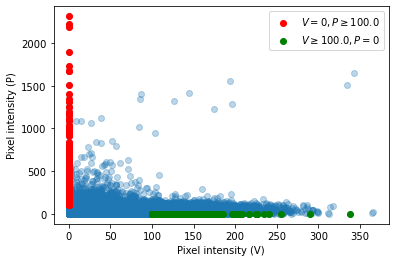

In [229]:
plotter, Pindx, Vindx = LP5.generate_scatter_plot_varNumpixels()

In [230]:
np.mean(LP5.check(Pindx,3))

376.43959731543623

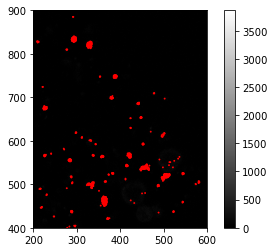

In [185]:
c

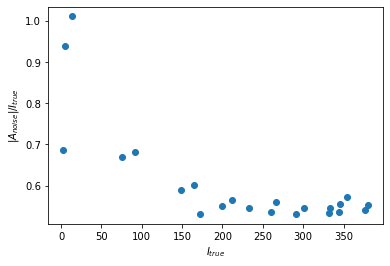

In [231]:
LP5.A_noise(Pindx)
plt.show()

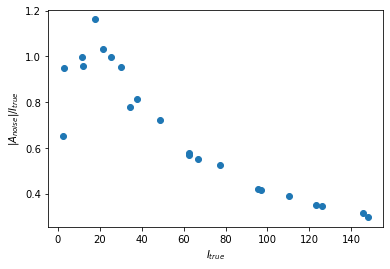

In [232]:
LP5.A_noise(Vindx)
plt.show()

In [142]:
NormData = LP5.normalize_data()

<module 'matplotlib.pyplot' from 'C:\\Users\\admin\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

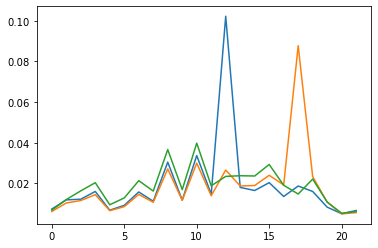

In [144]:
LP5.apply_kmeans(NormData,100,950,50,650,3)

<module 'matplotlib.pyplot' from 'C:\\Users\\admin\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

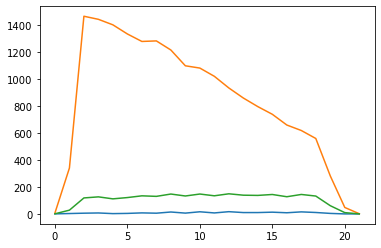

In [145]:
LP5.apply_kmeans(None,100,950,50,650,3)

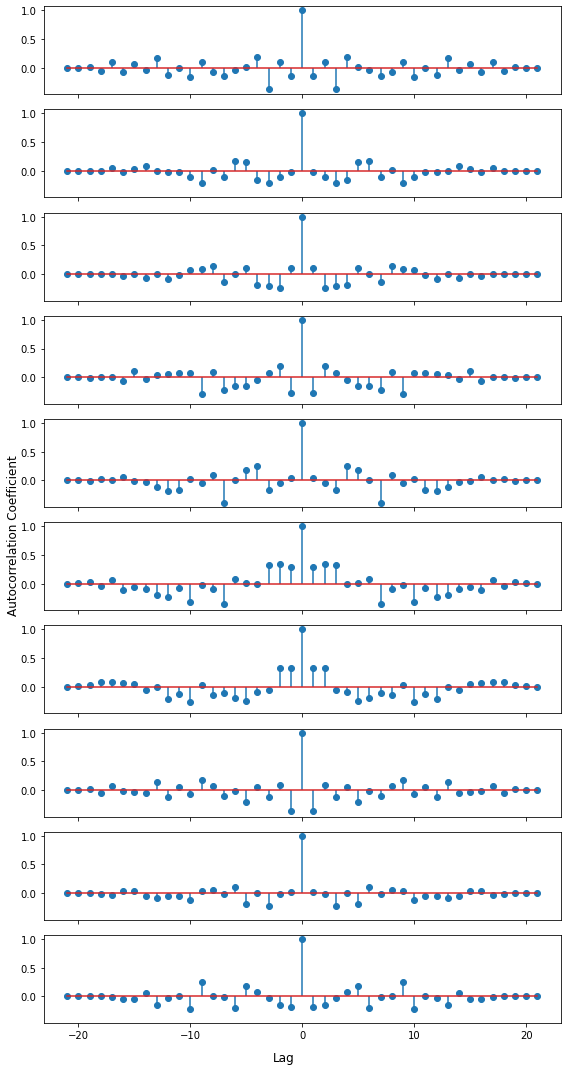

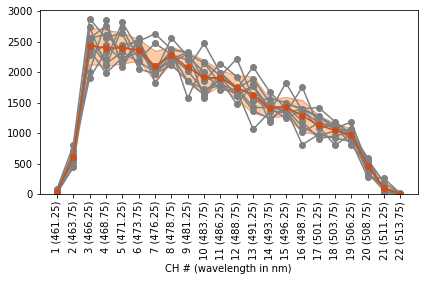

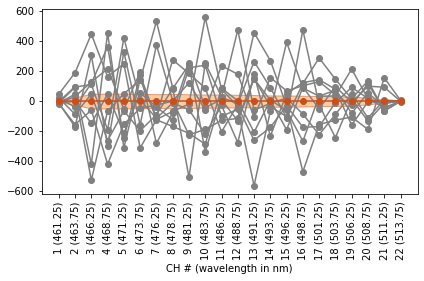

<Figure size 432x288 with 0 Axes>

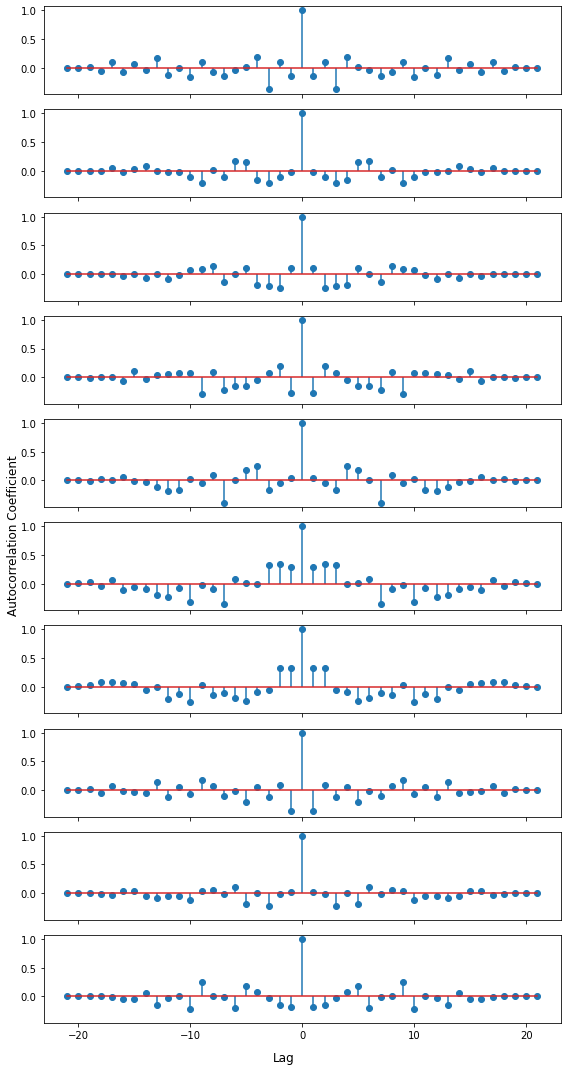

In [65]:
LP5.autocorrelation(Pindx)

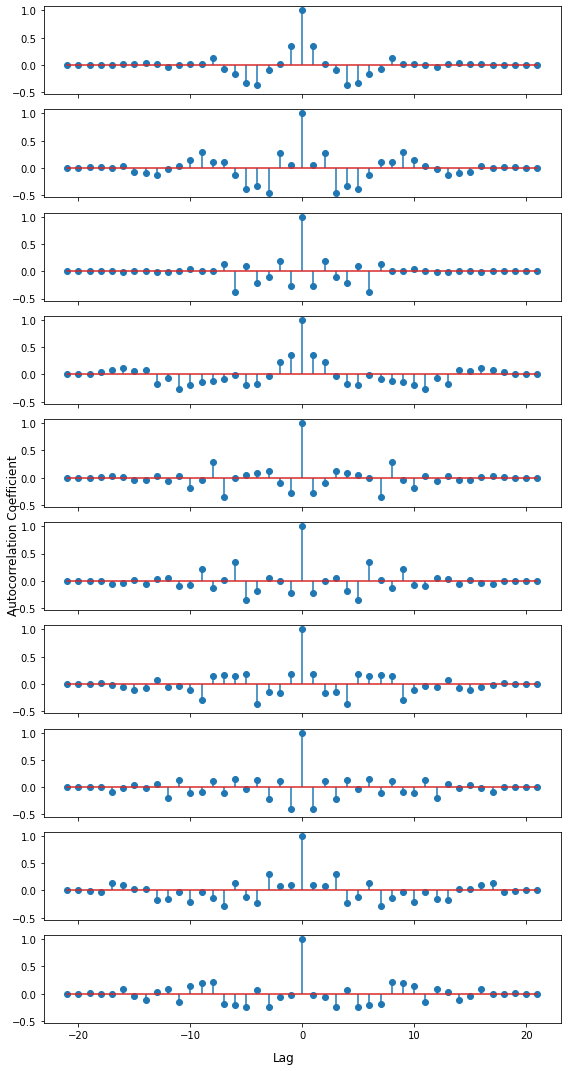

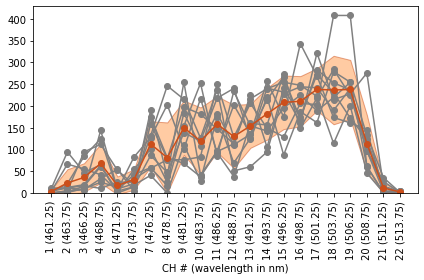

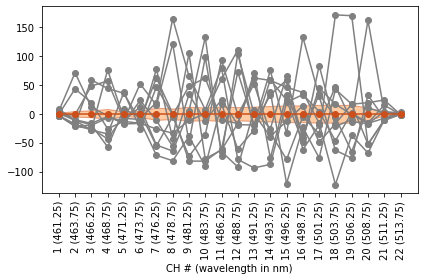

<Figure size 432x288 with 0 Axes>

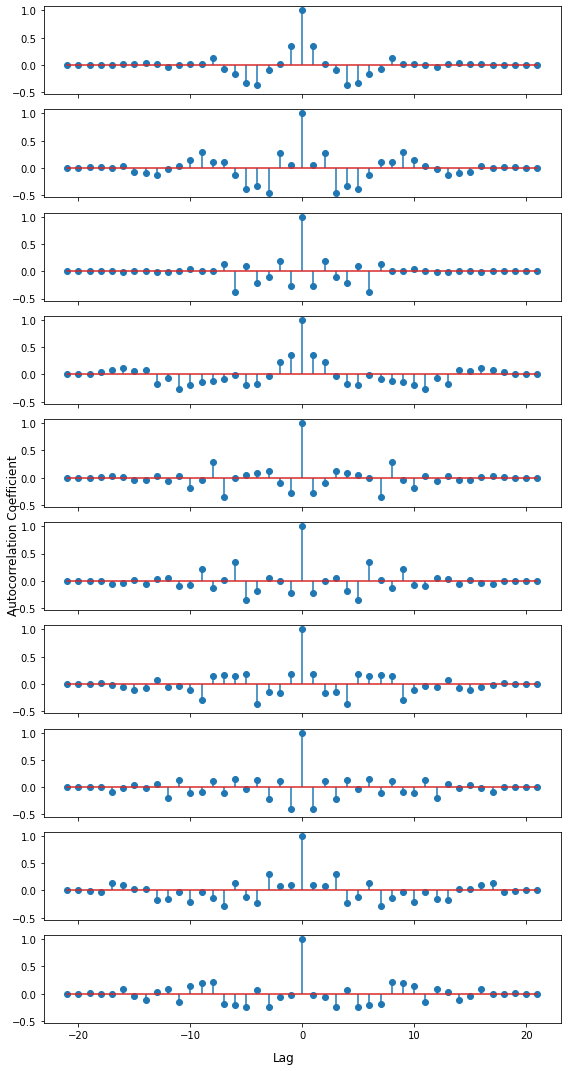

In [66]:
LP5.autocorrelation(Vindx)

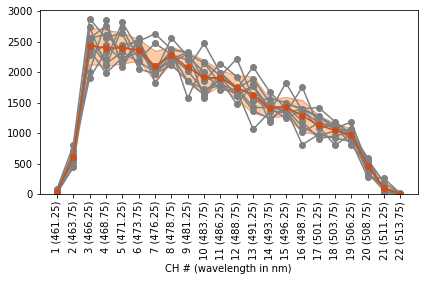

In [23]:
normPplot = LP5.generate_normSpectrumbyAVE(Pindx)
# normPplot.savefig('C:\\Users\\admin\\Desktop\\Comparison_plots\\SNR\\New_data\\normLP5_Perox.png', dpi=300)

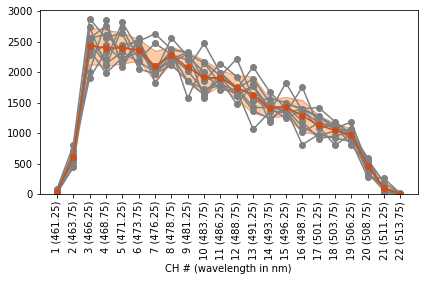

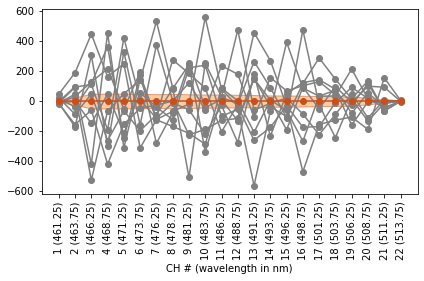

In [40]:
detrendP, mean_detrendP = LP5.detrend_poisson(Pindx)

In [30]:
mean_detrendP

array([-2.48689958e-15, -1.36424205e-13, -1.81898940e-13,  4.54747351e-14,
       -4.54747351e-14,  4.54747351e-14, -4.32009983e-13, -4.54747351e-14,
       -1.36424205e-13, -1.81898940e-13,  2.27373675e-14, -4.54747351e-14,
        1.13686838e-13, -2.27373675e-14, -4.54747351e-14, -2.27373675e-14,
       -1.81898940e-13, -2.16004992e-13,  5.68434189e-14,  6.82121026e-14,
       -7.81597009e-15,  2.22044605e-16])

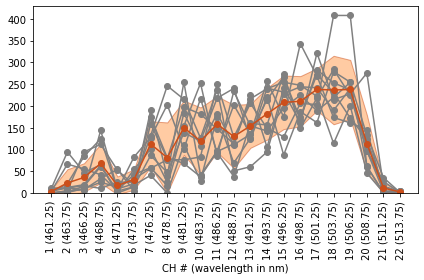

In [41]:
normVplot = LP5.generate_normSpectrumbyAVE(Vindx)
# normPplot.savefig('C:\\Users\\admin\\Desktop\\Comparison_plots\\SNR\\New_data\\normLP5_Vac.png', dpi=300)

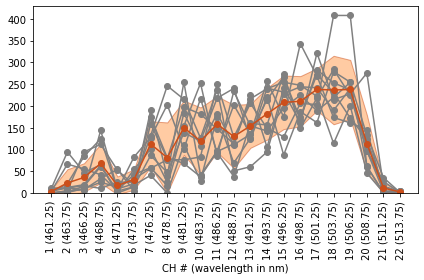

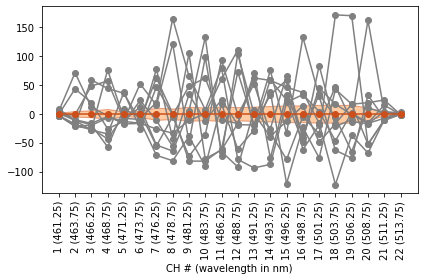

In [42]:
detrendV, mean_detrendV = LP5.detrend_poisson(Vindx)

In [35]:
mean_detrendV

array([ 0.00000000e+00, -1.42108547e-15, -2.48689958e-15, -8.52651283e-15,
        8.88178420e-16,  1.06581410e-15,  1.98951966e-14, -1.42108547e-15,
       -1.42108547e-14,  5.68434189e-15, -2.70006240e-14, -2.55795385e-14,
        1.98951966e-14, -1.42108547e-14, -1.13686838e-14, -1.70530257e-14,
        5.68434189e-15,  2.84217094e-15, -2.27373675e-14,  1.13686838e-14,
       -8.88178420e-16, -3.55271368e-16])

# Test: normalization code

In [55]:
# Your 3D matrix
M = np.random.rand(3, 4, 5)  # Example dimensions: (3, 4, 5)



In [59]:

# Integration bounds
z_min = 0
z_max = 4

# Perform definite integral along the z-axis
result = np.trapz(M, dx=1, axis=0)  # Adjust dx as needed

result_simps = simps(M, dx=1, axis=0) 

In [60]:
result

array([[0.9835437 , 1.40787948, 1.57921218, 0.78877793, 1.17209686],
       [1.56488573, 1.38801796, 0.5987879 , 1.46994689, 1.19645619],
       [0.65361778, 1.52315321, 1.00815003, 1.24007011, 1.49792617],
       [0.39617831, 1.06882883, 0.89016927, 0.86658073, 1.41387245]])

In [61]:
result_simps

array([[0.72556392, 1.43074078, 1.54712958, 0.6431217 , 1.19558718],
       [1.62969219, 1.34306456, 0.45326865, 1.43604267, 1.34537879],
       [0.47366573, 1.64907113, 1.15981466, 1.4203014 , 1.53685941],
       [0.35529557, 0.95326733, 0.80920169, 0.86780466, 1.37058279]])

In [66]:
def f1(x):
    return x**2
x = np.array([1,3,4])
y1 = f1(x)
Is = simps(y1,x)
It= np.trapz(y1,x)

In [67]:
Is

21.0

In [68]:
It

22.5

In [80]:
normalized_matrix = M / result_simps[np.newaxis,:, :]
normalized_matrix

array([[[1.30735303, 0.61215936, 0.55260374, 1.1767132 , 0.46681659],
        [0.52225028, 0.45543424, 0.45804078, 0.44443577, 0.24944317],
        [1.16824628, 0.4737265 , 0.26838704, 0.43180809, 0.5774005 ],
        [1.37089368, 0.98844674, 1.23073765, 0.73431237, 0.4470562 ]],

       [[0.14444239, 0.51597865, 0.47926315, 0.27351684, 0.51964752],
        [0.53976608, 0.46652923, 0.17895585, 0.47639052, 0.61069195],
        [0.12008642, 0.57635688, 0.63076627, 0.62689651, 0.52533299],
        [0.38493315, 0.37877325, 0.39994141, 0.50141038, 0.46841515]],

       [[1.11487741, 0.32392605, 0.53034367, 0.72921946, 0.45459334],
        [0.31868542, 0.67844883, 1.8261358 , 0.65000215, 0.30778904],
        [1.35140803, 0.22084598, 0.20854789, 0.06060588, 0.32126753],
        [0.08937372, 0.49646026, 0.16949669, 0.26004611, 0.67928321]]])

In [81]:
M

array([[[0.94856819, 0.87584136, 0.85494959, 0.75676979, 0.55811993],
        [0.8511072 , 0.61167759, 0.20761553, 0.63822872, 0.33559555],
        [0.55335823, 0.7812087 , 0.31127922, 0.61329763, 0.8873834 ],
        [0.48707245, 0.94225398, 0.99591499, 0.6372397 , 0.61272753]],

       [[0.10480219, 0.73823169, 0.74148219, 0.17590461, 0.62128391],
        [0.87965256, 0.62657888, 0.08111508, 0.68411712, 0.82161199],
        [0.05688082, 0.95045349, 0.73157197, 0.89038199, 0.80736295],
        [0.13676504, 0.36107216, 0.32363327, 0.43512627, 0.64200174]],

       [[0.80891483, 0.46345421, 0.82051039, 0.46897685, 0.54350597],
        [0.51935913, 0.91120058, 0.82773012, 0.93343083, 0.41409285],
        [0.64011568, 0.36419074, 0.24187691, 0.08607862, 0.49374303],
        [0.03175409, 0.47325934, 0.13715701, 0.22566923, 0.93101388]]])

In [90]:
M.shape

(3, 4, 5)

In [84]:
# dictionary['PV_SS1024_Pnh3p2_PDT6p2_445nm_LP5_6bins'] = np.empty([1024,1024,9])

imageTemp = bioformats.load_image(
            path='C:\\Users\\admin\\Downloads\\Bins\\PV_SS1024_Pnh3p2_PDT6p2_445nm_LP5_6bins.nd2' ,
            c=None,
            rescale = False
)

In [85]:
imageTemp.shape

(1024, 1024, 9)

In [95]:
simps(imageTemp, np.array([a+1 for a in range(9)]),  axis=-1).shape

(1024, 1024)

In [4]:
a = np.array([[1,2],[3,4]])

In [6]:
b = np.array([1,1])

In [9]:
a-b

array([[0, 1],
       [2, 3]])

In [245]:
a = np.array([[[1,2],
               [2,4]],
              
              [[3,1],
               [4,2]]])

In [246]:
ind_2 = np.where(a==2)
mask =  np.ones(a[0].shape)
#mask[ind_2[1:3]] = 0 
mask[ind_2[1],ind_2[2]] = 0

In [247]:
a*mask[np.newaxis,:,:]

array([[[1., 0.],
        [0., 0.]],

       [[3., 0.],
        [0., 0.]]])

In [244]:
xy = ind_2[1:3]

In [211]:
a = np.array([[[1,2],
               [2,4]],
              
              [[3,1],
               [4,2]]])
ind_2 = np.where(a==2)
for D in range(a.shape[0]):
    print(a[D,ind_2[1],ind_2[2]].flatten())

[2 2 4]
[1 4 2]


In [197]:
a[1,ind_2[1:3][0],ind_2[1:3][1]]

array([1, 4, 2])

In [210]:
ind_2[2]

array([1, 0, 1], dtype=int64)

In [206]:
a[]

array([[[3, 1],
        [4, 2],
        [4, 2]],

       [[4, 2],
        [3, 1],
        [4, 2]]])

# New data (LP = 10, Pnh = 3.8 AU)

In [4]:
CFP = Spectrum_Analysis('LargerPnh\\CFP1','LargerPnh\\CFP1_unmixed2',2.5,1024,22,'P','V',461.25)

TypeError: __init__() missing 1 required positional argument: 'start_nm'

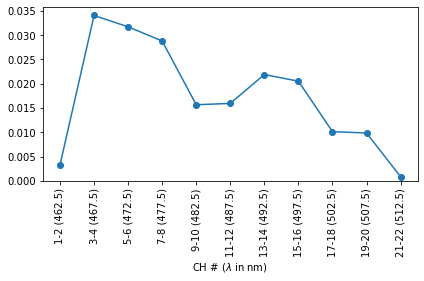

In [7]:
CFP.generate_normSpectrum(291, 617, 2)
plt.show()

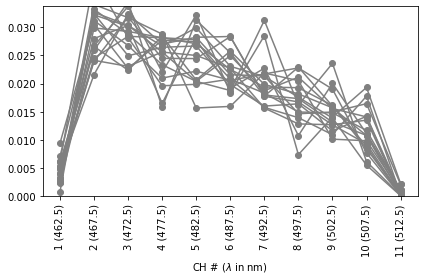

In [227]:
x_list = [466, 180, 274, 488, 327, 291, 273, 275, 305, 187, 522, 521, 292, 274, 279, 306, 305]
y_list = [487, 724, 666, 652, 613, 617, 666, 667, 642, 764, 33, 33,  618, 667, 666, 638, 643]
for j in range(len(x_list)):
    CFP.generate_normSpectrum(x_list[j], y_list[j], 2)
 
plt.ylim(bottom=0)
plt.show()

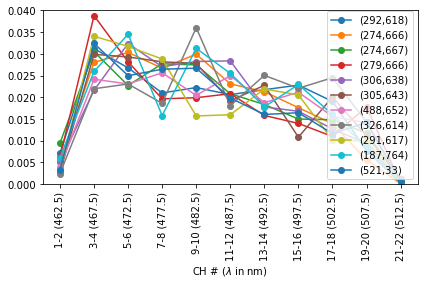

In [286]:
x_list = [292, 274, 274, 279, 306, 305, 488, 326, 291, 187, 521]
y_list = [618, 666, 667, 666, 638, 643, 652, 614, 617, 764, 33]
for j in range(len(x_list)):
    CFP.generate_normSpectrum(x_list[j], y_list[j], 2)
 
plt.ylim(bottom=0, top = 0.04)
plt.legend()
plt.show()

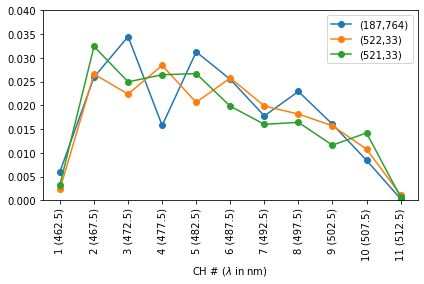

In [262]:
x_list = [187, 522, 521]
y_list = [764, 33, 33]
for j in range(len(x_list)):
    CFP.generate_normSpectrum(x_list[j], y_list[j], 2)
 
plt.ylim(bottom=0, top = 0.04)
plt.legend()
plt.show()

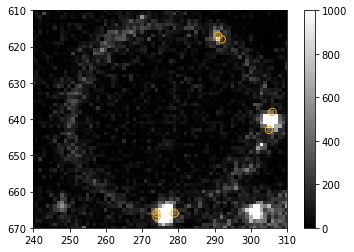

In [287]:
CFP.pix_in_image(np.stack((np.array(y_list),np.array(x_list))),13,'orange',1000)
# Set the y-axis limits after adding circles
plt.gca().set_ylim(bottom=670, top=610)
plt.gca().set_xlim(left=240, right=310)

plt.savefig('C:\\Users\\admin\\Desktop\\Comparison_plots\\SNR\\New_data\\mixed_sample.png', dpi=300)
# Show the plot
plt.show()

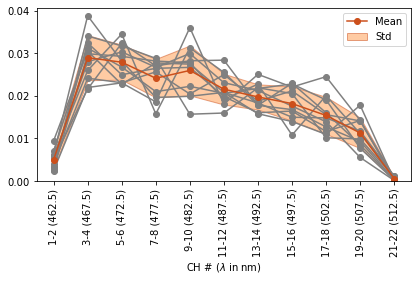

In [288]:
CFP.generate_normSpectrum_combi(np.stack((np.array(y_list),np.array(x_list))),2)
plt.savefig('C:\\Users\\admin\\Desktop\\Comparison_plots\\SNR\\New_data\\mixed_spectrum.png', dpi=300)
plt.show()

In [201]:
np.array(range(22))[1:1+2] + 1

array([2, 3])

In [8]:
no_sat_image, ind_sat = CFP.remove_saturated_pix()

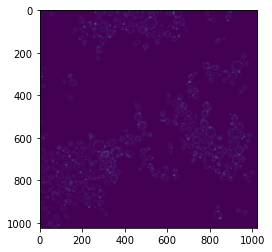

In [30]:
plt.imshow(no_sat_image[:,:,15])
plt.show()

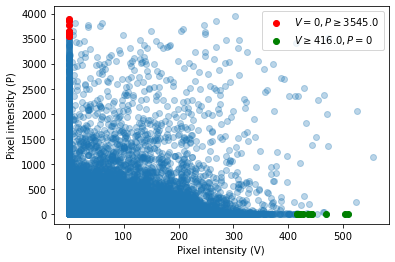

In [9]:
plotter_2p5, Pindx_2p5, Vindx_2p5 = CFP.generate_scatter_plot_varNumpixels(False,10)
# plotter_2p5.savefig('C:\\Users\\admin\\Desktop\\Comparison_plots\\SNR\\New_data\\CFP_scatter_nosatpix.png', dpi=300)
plt.show()

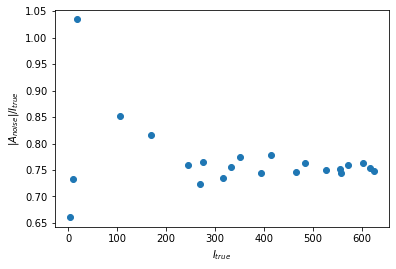

In [258]:
plot = CFP.A_noise(Pindx_2p5)
plot.savefig('C:\\Users\\admin\\Desktop\\Comparison_plots\\Noise_modelling\\PNoise_Itrue.png', dpi=300)
plt.show()

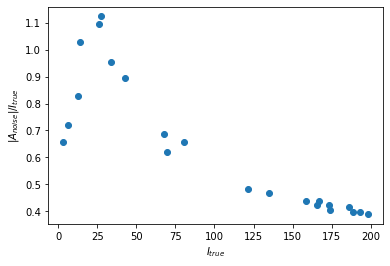

In [259]:
plot = CFP.A_noise(Vindx_2p5)
plot.savefig('C:\\Users\\admin\\Desktop\\Comparison_plots\\Noise_modelling\\VNoise_Itrue.png', dpi=300)
plt.show()

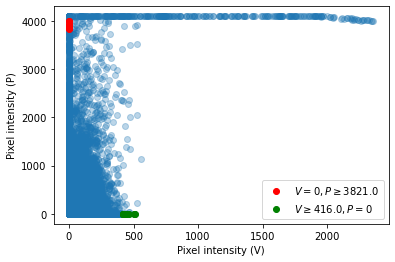

In [68]:
plotter_2p5, Pindx_2p5, Vindx_2p5 = CFP.generate_scatter_plot()
plotter_2p5.savefig('C:\\Users\\admin\\Desktop\\Comparison_plots\\SNR\\New_data\\CFP_scatter.png', dpi=300)

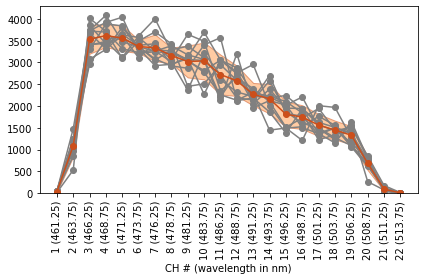

In [281]:
normPplot = CFP.generate_normSpectrumbyAVE(Pindx_2p5)
plt.savefig('C:\\Users\\admin\\Desktop\\Comparison_plots\\SNR\\New_data\\norm_Perox.png', dpi=300)

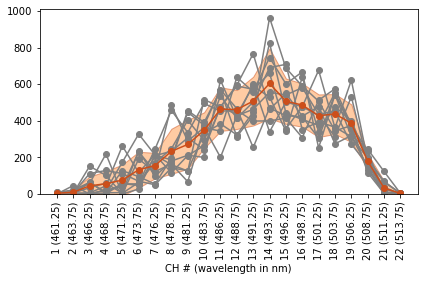

In [282]:
normVplot = CFP.generate_normSpectrumbyAVE(Vindx_2p5)
plt.savefig('C:\\Users\\admin\\Desktop\\Comparison_plots\\SNR\\New_data\\norm_Vac.png', dpi=300)

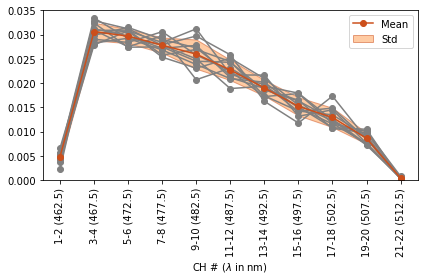

In [277]:
CFP.generate_normSpectrum_combi(Pindx_2p5,2)
plt.savefig('C:\\Users\\admin\\Desktop\\Comparison_plots\\SNR\\New_data\\norm_Perox_2CH.png', dpi=300)
plt.show()

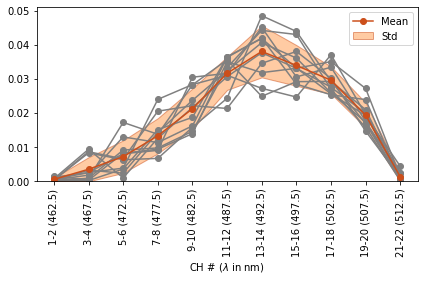

In [278]:
CFP.generate_normSpectrum_combi(Vindx_2p5,2)
plt.savefig('C:\\Users\\admin\\Desktop\\Comparison_plots\\SNR\\New_data\\norm_Vac_2CH.png', dpi=300)
plt.show()

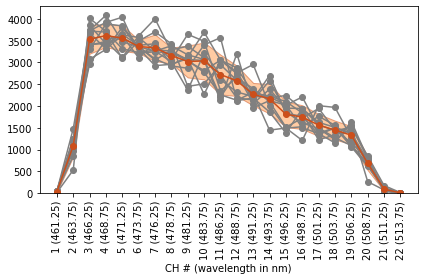

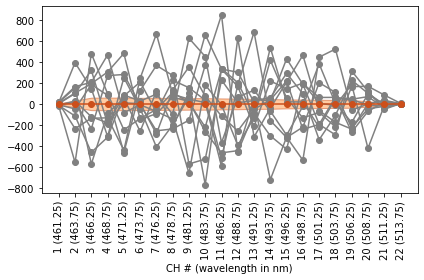

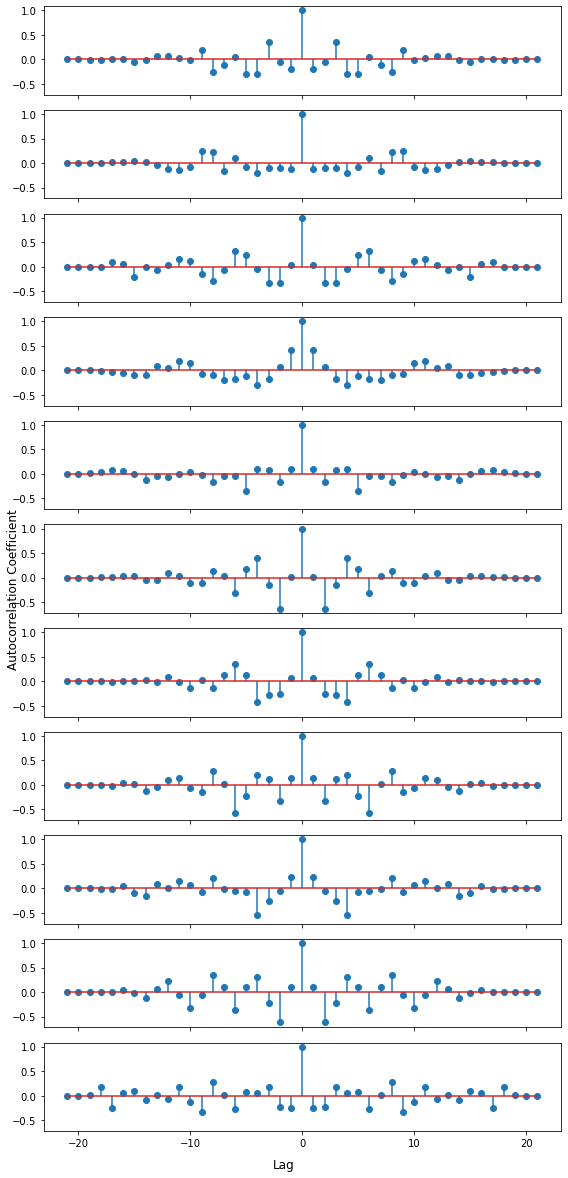

In [10]:
CFP.autocorrelation(Pindx_2p5)
plt.show()

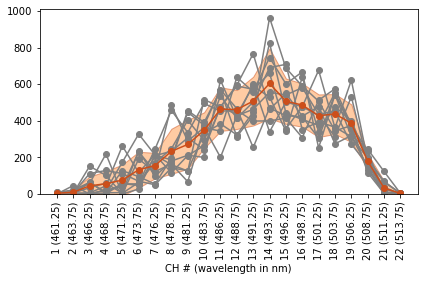

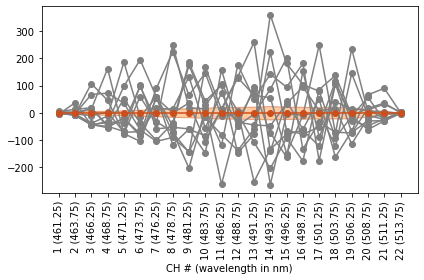

<Figure size 432x288 with 0 Axes>

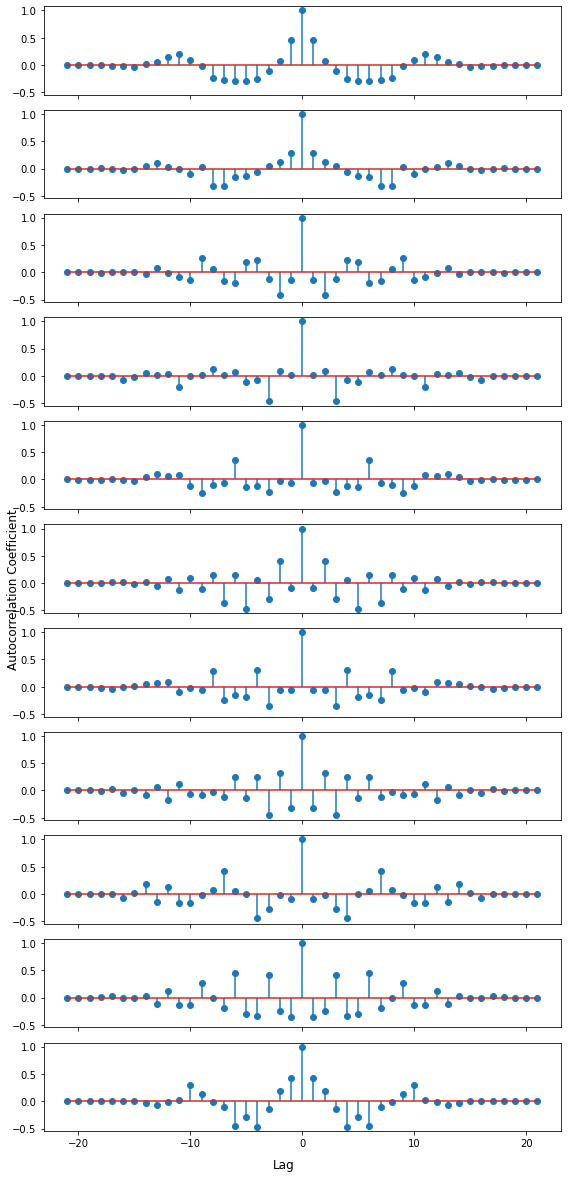

In [73]:
CFP.autocorrelation(Vindx_2p5)
plt.show()

In [178]:
NormData = CFP.normalize_data()

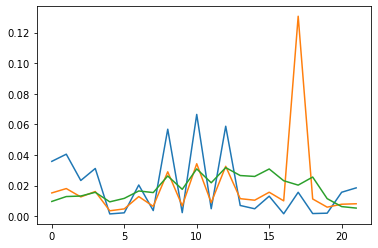

In [184]:
estimated_spectra_norm = CFP.apply_kmeans(NormData,0,1024,0,1024,3)

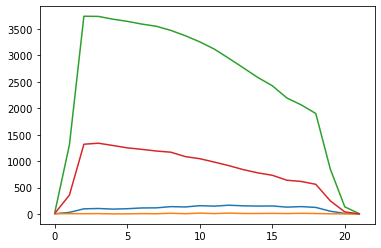

In [185]:
estimated_spectra = CFP.apply_kmeans(None,0,1024,0,1024,4)

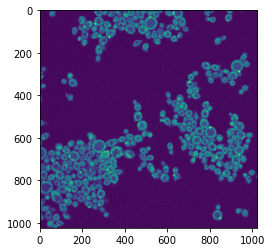

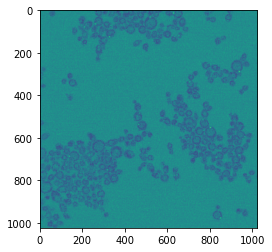

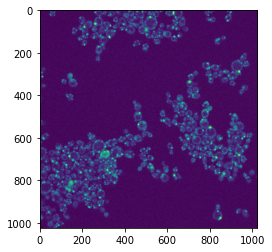

In [183]:
Comp1, Comp2, Comp3 = CFP.generate_NMF_comp(0,1024,0,1024)

plt.imshow(Comp1, )
plt.show()

plt.imshow(Comp2)
plt.show()

plt.imshow(Comp3)
plt.show()

# Dye 

In [299]:
Dye = Spectrum('CH15_Dataset_0',False,2.5,512,32,'Dye','Dye',486)

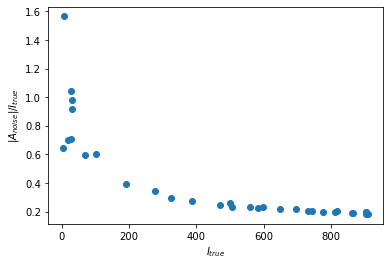

In [308]:
Dye.A_noise(np.stack((np.array(range(30,400)),np.array(range(30,400)))))
plt.savefig('C:\\Users\\admin\\Desktop\\Comparison_plots\\SNR\\New_data\\Dye_noise.png', dpi=300)

In [302]:
np.stack((np.array(range(30,80)),np.array(range(30,80))))

array([[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
        46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
        78, 79],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
        46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
        78, 79]])

# Autocorrelation

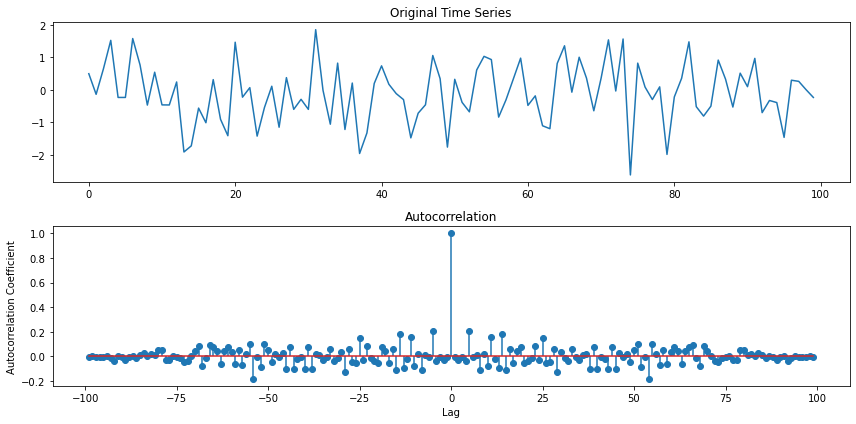

In [55]:
# Generate a sample time series
np.random.seed(42)
time_series = np.random.randn(100)

# Calculate autocorrelation using NumPy's correlate function
lags = np.arange(-len(time_series) + 1, len(time_series))
autocorr = np.correlate(time_series, time_series, mode='full') / np.max(np.correlate(time_series, time_series, mode='full'))

# Plot the original time series
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_series)
plt.title('Original Time Series')

# Plot autocorrelation
plt.subplot(2, 1, 2)
plt.stem(lags, autocorr)
plt.title('Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Coefficient')

plt.tight_layout()
plt.show()

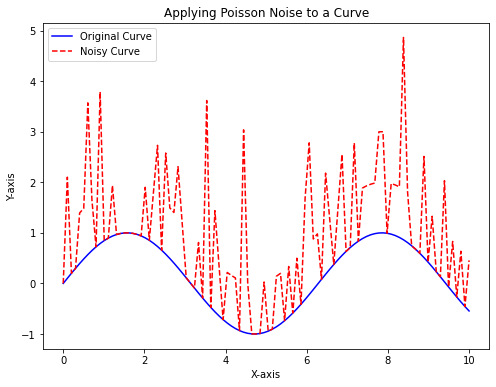

In [278]:
# Generate a sinusoidal curve as the original data
x = np.linspace(0, 10, 100)
original_curve = np.sin(x)

# Set the average rate (lambda parameter) for the Poisson distribution
average_rate = 0.7

# Add Poisson-distributed noise to each point on the curve
poisson_noise = np.random.poisson(average_rate, size=len(x))
noisy_curve = original_curve + poisson_noise

# Plot the original curve and the curve with Poisson noise
plt.figure(figsize=(8, 6))
plt.plot(x, original_curve, label='Original Curve', color='blue')
plt.plot(x, noisy_curve, label='Noisy Curve', color='red', linestyle='dashed')
plt.title('Applying Poisson Noise to a Curve')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

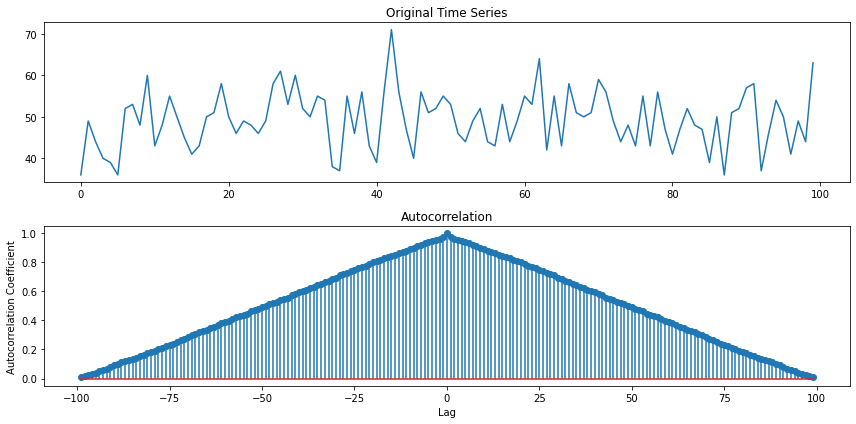

In [53]:

# Generate a sinusoidal curve as the original data
x = np.linspace(0, 10, 100)

# Set the average rate (lambda parameter) for the Poisson distribution
average_rate = 50

# Add Poisson-distributed noise to each point on the curve
poisson_noise = np.random.poisson(average_rate, size=len(x))

# Calculate autocorrelation using NumPy's correlate function
lags = np.arange(-len(poisson_noise) + 1, len(poisson_noise))
autocorr = np.correlate(poisson_noise, poisson_noise, mode='full') / np.max(np.correlate(poisson_noise, poisson_noise, mode='full'))

# Plot the original time series
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(poisson_noise)
plt.title('Original Time Series')

# Plot autocorrelation
plt.subplot(2, 1, 2)
plt.stem(lags, autocorr)
plt.title('Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Coefficient')

plt.tight_layout()
plt.show()

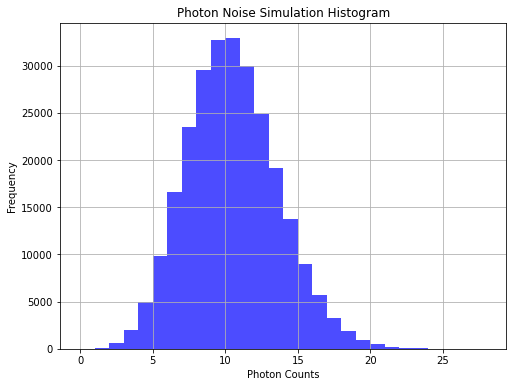

In [54]:
# Parameters
intensity = 100   # Example intensity
exposure_time = 0.1  # Example exposure time in seconds
height, width = 512, 512  # Example image dimensions

# Calculate average photon count
lambda_val = intensity * exposure_time

# Generate photon counts
photon_counts = np.random.poisson(lambda_val, size=(height, width))

# Plot histogram of photon counts
plt.figure(figsize=(8, 6))
plt.hist(photon_counts.flatten(), bins=range(0, np.max(photon_counts) + 1), color='blue', alpha=0.7)
plt.title('Photon Noise Simulation Histogram')
plt.xlabel('Photon Counts')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Ali's data

In [ ]:
Leu = Spectrum_Analysis('Ali_data\\LeuExp100Red_01','Ali_data\\Unmixed.LeuExp100Red_01',2.5,1024,22,'M','LD',461.25)

# Scratch

In [5]:
Raw_data = np.empty([1024, 1024, 22])
image_temp = bioformats.load_image(
    path=f'C:\\Users\\admin\\OneDrive - Washington University in St. Louis\\PhD\\Research\\Biophys\\image_data\\LargerPnh\\CFP1.nd2',
    c=None,
    rescale=False
)
Raw_data[:, :, :] = image_temp

In [10]:
Raw_data.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [9]:
image_temp.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [13]:
Raw_data2 = np.array(image_temp)